# Forecasting

In [5]:
# imports

# for eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for ML
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor


In [8]:
train = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\train.csv', parse_dates=['date'])
test = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\test.csv', parse_dates=['date'])
sample_submission = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\sample_submission.csv')

# Baseline RMSE

Baseline model to get a benchmark
- Predict mean sales per store
- Evaluate that on a validation set

RMSLE: logarithmic difference between predictions and actual value

In [3]:
# Train/validation split (time-based: last 3 months = validation)
cutoff_date = "2017-10-01"
train_baseline = train[train["date"] < cutoff_date]
val_baseline   = train[train["date"] >= cutoff_date]

# Compute mean sales per (store, item) from training part
mean_sales = train_baseline.groupby(["store", "item"])["sales"].mean()

# Predict validation: use group mean (fallback to global mean if missing)
val_preds = val_baseline.set_index(["store","item"]).index.map(
    lambda idx: mean_sales.get(idx, train_baseline["sales"].mean())
)

# True values
y_true = val_baseline["sales"].values
y_pred = np.array(val_preds)

# RMSLE (Kaggle metric)
score = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Baseline RMSLE: {score:.5f}")

Baseline RMSLE: 0.24273


# LightGBM Model

gradient boosting model
- Handles categorical features efficiently.
- Works well with lag/rolling features for time-series.
- Provides fast training & strong accuracy.

Features: calendar + lag + rolling.

Model: LightGBM Regressor with early stopping.

In [4]:
# 0) concat train+test so features exist on both (safe for lags)
tr = train.copy(); te = test.copy()
tr["split"] = "train"; te["split"] = "test"
df = pd.concat([tr, te], ignore_index=True).sort_values(["store","item","date"])
df.reset_index(drop=True, inplace=True)

# 1) calendar features
dt = df["date"]
df["dow"]       = dt.dt.dayofweek.astype("int8")
df["is_weekend"]= df["dow"].isin([5,6]).astype("int8")
df["month"]     = dt.dt.month.astype("int8")
df["year"]      = dt.dt.year.astype("int16")
df["day"]       = dt.dt.day.astype("int8")
df["woy"]       = dt.dt.isocalendar().week.astype("int16")
df["quarter"]   = dt.dt.quarter.astype("int8")
df["m_start"]   = dt.dt.is_month_start.astype("int8")
df["m_end"]     = dt.dt.is_month_end.astype("int8")

# 2) lags & rolling (shift first to avoid leakage)
g = df.groupby(["store","item"], group_keys=False)
for L in (1,7,14,28):
    df[f"lag_{L}"] = g["sales"].shift(L)
df["roll7"]  = g["sales"].shift(1).rolling(7,  min_periods=1).mean()
df["roll28"] = g["sales"].shift(1).rolling(28, min_periods=1).mean()

# 3) dtypes (smaller & categorical for LGBM)
for c in ["store","item"]:
    df[c] = df[c].astype("int16").astype("category")
num_cols = ["lag_1","lag_7","lag_14","lag_28","roll7","roll28"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, downcast="float")

# 4) split back + time-based validation
feat_cols = ["store","item","dow","is_weekend","month","year","day","woy","quarter","m_start","m_end",
             "lag_1","lag_7","lag_14","lag_28","roll7","roll28"]

df_tr = df[df["split"]=="train"].copy()
df_te = df[df["split"]=="test"].copy()

cutoff = pd.Timestamp("2017-10-01")  # last ~3 months as validation
tr_mask = df_tr["date"] < cutoff
va_mask = df_tr["date"] >= cutoff

X_train = df_tr.loc[tr_mask, feat_cols]
y_train = df_tr.loc[tr_mask, "sales"].astype("float32")
X_val   = df_tr.loc[va_mask, feat_cols]
y_val   = df_tr.loc[va_mask, "sales"].astype("float32")
X_test  = df_te[feat_cols]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Shapes: (867000, 17) (46000, 17) (45000, 17)


In [6]:

cat_feats = ["store","item","dow","month","quarter"]  # small, effective set

model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[]
    # early_stopping removed in some LightGBM builds; if available:
    # callbacks=[lightgbm.early_stopping(100), lightgbm.log_evaluation(100)]
)

# Evaluate (RMSLE)
val_pred = np.clip(model.predict(X_val), 0, None)
rmsle = np.sqrt(mean_squared_log_error(y_val, val_pred))
print(f"Validation RMSLE: {rmsle:.5f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 17
[LightGBM] [Info] Start training from score 52.121505
Validation RMSLE: 0.15807


# Prediction on test dataset

In [10]:
test_pred = np.clip(model.predict(X_test), 0, None)
sub = sample_submission.copy()
sub["sales"] = test_pred
print(sub.head())
sub.to_csv("predictions.csv", index=False)

   id      sales
0   0  12.199787
1   1  12.050390
2   2  12.402985
3   3  13.604758
4   4  14.364701


# Results

Baseline (mean predictor): RMSLE ≈ 0.243
LightGBM with calendar + lag + rolling features: RMSLE ≈ 0.15807

the feature-engineered model clearly outperforms the naive baseline.

# Plot predictions

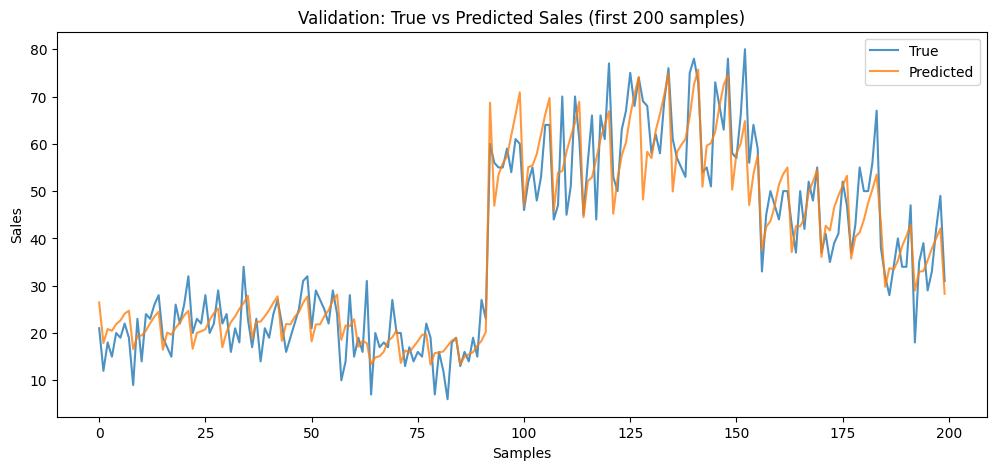

In [11]:
plt.figure(figsize=(12,5))
plt.plot(y_val.values[:200], label="True", alpha=0.8)
plt.plot(val_pred[:200], label="Predicted", alpha=0.8)
plt.title("Validation: True vs Predicted Sales (first 200 samples)")
plt.xlabel("Samples")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Save model

In [12]:
import joblib

joblib.dump(model, "lgbm_demand_model.pkl")
print("Model saved as lgbm_demand_model.pkl")

Model saved as lgbm_demand_model.pkl
